# Timeseries classification from scratch

**Author:** [hfawaz](https://github.com/hfawaz/)<br>
**Date created:** 2020/07/21<br>
**Last modified:** 2023/11/10<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.

## Introduction

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [2]:
data = pd.read_csv('/content/service_called.csv')
data.head()
# main_dataframe = data.transpose()
# main_dataframe.head()
# column_name = main_dataframe.iloc[0]
data.drop(data.columns[0], axis=1 , inplace=True)
data['future']=data['post_storage_read_posts_server'].shift(-1)
# main_dataframe.columns = column_name
# main_dataframe

# indexes = [item for item in range(0,5760)]
# main_dataframe.index=indexes
# main_dataframe.head()

scaler = MinMaxScaler()
for column in data.columns:
  data[column] =  scaler.fit_transform(data[[column]])

main_dataframe = data.to_numpy()

In [3]:



# root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"
data = main_dataframe # pd.read_csv('/content/number_services_called.csv').fillna(0).to_numpy()



In [4]:
print(data[0])
number_train = int(0.7 * data.shape[0])
print(number_train)
x_train = data[ :number_train,:-1]
y_train = data[:number_train,-1]

x_test = data[ number_train:,:-1]
y_test = data[number_train:,-1]

# print(x_train.shape , y_train.shape , x_test.shape , y_test.shape)
print(x_train[0])
print(y_train[0])

[0.375      0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.         0.
 0.         0.25       0.33333333 0.39285714 0.39285714 0.39285714
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.         0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.60606061]
4031
[0.375      0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.         0.
 0.         0.25       0.33333333 0.39285714 0.39285714 0.39285714
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.         0.25       0.25       0.25
 0.25       0.25       0.25       0.25      ]
0.6060606060606061


In [5]:
y_train

array([0.60606061, 0.27272727, 0.51515152, ..., 0.24242424, 0.57575758,
       0.45454545])

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

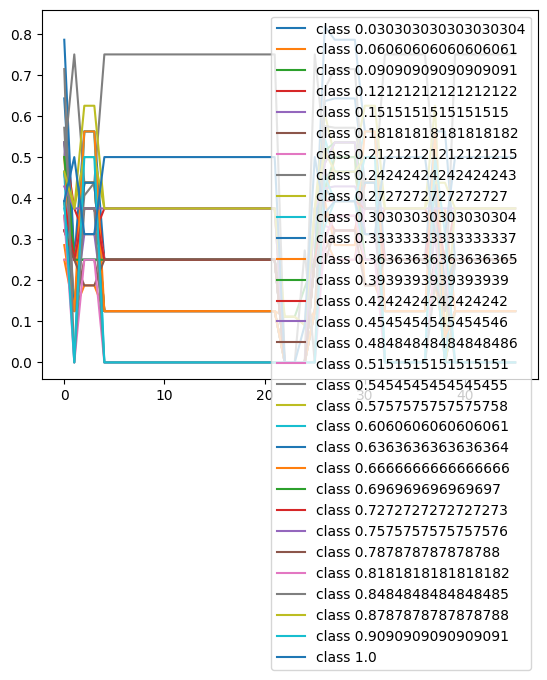

In [6]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    if(len(c_x_train)!=0):
      plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries are already in a single length (500). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [7]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape , x_test.shape)

(4031, 46, 1) (1729, 46, 1)


Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [8]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [9]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [10]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

In [19]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Add, LayerNormalization

def make_complex_lstm_model(input_shape):
    input_layer = Input(input_shape)

    # First LSTM block
    lstm1 = LSTM(64, return_sequences=True)(input_layer)
    dropout1 = Dropout(0.2)(lstm1)
    norm1 = LayerNormalization()(dropout1)

    # Second LSTM block
    lstm2 = LSTM(64, return_sequences=True)(norm1)
    dropout2 = Dropout(0.2)(lstm2)
    norm2 = LayerNormalization()(dropout2)

    # Third LSTM block with residual connection
    lstm3 = LSTM(64, return_sequences=True)(norm2)
    dropout3 = Dropout(0.2)(lstm3)
    norm3 = LayerNormalization()(dropout3)
    residual3 = Add()([norm1, norm3])

    # Fourth LSTM block
    lstm4 = LSTM(64, return_sequences=False)(residual3)
    dropout4 = Dropout(0.2)(lstm4)
    norm4 = LayerNormalization()(dropout4)

    # Dense layers
    dense1 = Dense(64, activation='relu')(norm4)
    output_layer = Dense(1, activation='linear')(dense1)  # Assuming a regression task

    return Model(inputs=input_layer, outputs=output_layer)

# Example usage:
# Assuming x_train has the shape (num_samples, timesteps, num_features)
model = make_complex_lstm_model(input_shape=(x_train.shape[1], x_train.shape[2]))
keras.utils.plot_model(model, show_shapes=True)

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 46, 1)]              0         []                            
                                                                                                  
 lstm_20 (LSTM)              (None, 46, 64)               16896     ['input_8[0][0]']             
                                                                                                  
 dropout_19 (Dropout)        (None, 46, 64)               0         ['lstm_20[0][0]']             
                                                                                                  
 layer_normalization_18 (La  (None, 46, 64)               128       ['dropout_19[0][0]']          
 yerNormalization)                                                                          

## Train the model

In [12]:
epochs = 50
batch_size = 64

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    # ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mse","mae","mape"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/50
51/51 [==============================] - 21s 54ms/step - loss: 0.1293 - mse: 0.1293 - mae: 0.2488 - mape: 67.7465 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1172 - val_mape: 28.1839
Epoch 2/50
51/51 [==============================] - 1s 22ms/step - loss: 0.0321 - mse: 0.0321 - mae: 0.1420 - mape: 40.8197 - val_loss: 0.0204 - val_mse: 0.0204 - val_mae: 0.1132 - val_mape: 27.7151
Epoch 3/50
51/51 [==============================] - 1s 21ms/step - loss: 0.0263 - mse: 0.0263 - mae: 0.1297 - mape: 37.5491 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.1036 - val_mape: 28.9399
Epoch 4/50
51/51 [==============================] - 1s 28ms/step - loss: 0.0227 - mse: 0.0227 - mae: 0.1197 - mape: 35.1043 - val_loss: 0.0171 - val_mse: 0.0171 - val_mae: 0.1061 - val_mape: 31.9568
Epoch 5/50
51/51 [==============================] - 2s 33ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1160 - mape: 34.5387 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.1063 - val_mape: 32.2757
Epoc

KeyboardInterrupt: 

## Evaluate model on test data

In [ ]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

## Plot the model's training and validation loss

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.

In [ ]:
# Generate predictions for the validation set
val_predictions = model.predict(train_test_split)

